In [1]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../../cds-backend/code/')
import cds_eua3 as eua
# import numbaprocess
import copy
import glob
from numba import njit
import pandas
import glob
import pickle
import matplotlib
import matplotlib.pyplot as plt
import h5py as h5

def request(rqdict, source, cds='_test', remove_file=True):
    """
    Remember to UPDATE the file .cdsapirc on the server home directory with the CORRECT cds address!
    See e.g. https://cds-test.copernicus-climate.eu/cdsapp#!/dataset/insitu-observations-igra-baseline-network?tab=form 
    """
    if cds != '_test':
        cds = ''
    t0 = time.time()

    c = cdsapi.Client()
    print(c)
    r = c.retrieve(
        source, rqdict)
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download' + cds + '/' )
    z.close()
    return

igra = 'insitu-observations-igra-baseline-network'

# Fill the request form 
"""
out = request({
    'source': 'IGRA_H',# 'IGRA'
    'variable':['air_temperature'],
    'period':'2009-01-01/2010-12-31',
#     'format': 'csv-lev.zip', # no format = .nc
    'station_name':'AUM00011035',
},igra, remove_file=False)
"""

# load data for a list of stations (IGRA, RHARM)
stations = ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408']

### TO DO
# Here: select the name of the download directory according  to TEST or PUB
# You must change the API file .cdsapi accordingly before the download !!!

cds  = '_test'
cds = ''
out_dir =  'download' + cds



### Download IGRA-RHARM data from CDS / CDSTEST

In [2]:
# container dictionaries for all the downloaded data in the form of pandas dataframe
all_HARM_df = {} 
all_IGRA_df = {}

all_HARM_df_test = {}
all_IGRA_df_test = {}

stdplevs = [ i*100 for i in [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0] ]

# Download both public CDS and TEST RHARM
# Loop over the station list, and download data from IGRA and RHARM as csv file.
for cds in ['_test' , '']: 
    # copy correct cdsapirc file 
    if 'test' in cds:
        os.system ( 'cp /users/staff/federico/cdsapirc_TEST.txt  /users/staff/federico/.cdsapirc' )
    else:
        os.system ('cp /users/staff/federico/cdsapirc_PUB.txt  /users/staff/federico/.cdsapirc' )

    out_dir =  'download' + cds

    for s in stations:
        out = request({
        'source': 'IGRA_H',# 'IGRA'
        'variable':['air_temperature'],
        'period':'2009-01-01/2010-12-31',
        'format': 'csv-lev.zip',
        'station_name': s,
        'archive_type': 'harmonized_global_radiosonde_archive',

        },igra, cds=cds, remove_file=False)


        files = glob.glob(out_dir+'/*.csv')


        file_dest = out_dir + '/' + s + '_RHARM_data.csv'
        for f in files:
            if '.csv' in f and 'data' not in f and '_IGRA' not in f :
                os.rename( f, file_dest )

        # reading the data as pandas dataframe
        df = pd.read_csv(file_dest, skiprows=14)
        # storing only standard pressure levels
        df = df[df.air_pressure.isin(stdplevs ) ]
        df =df.sort_values(by=['report_timestamp'])
        # da = eua.CDMDataset('download/USM00070308_IGRA_data.nc').to_dataframe() ### example
        all_HARM_df[s] = df 

        if 'test' in cds:
            all_HARM_df_test[s] = df 

        else:
            all_HARM_df[s] = df 
            
        out = request({
        'source': 'IGRA',# 'IGRA'
        'variable':['air_temperature'],
        'period':'2009-01-01/2010-12-31',
        'format': 'csv-lev.zip',
        'station_name': s,
        'archive_type': 'global_radiosonde_archive',

        },igra, cds=cds, remove_file=False)

        filess = glob.glob(out_dir+'/*.csv')
        file_des = out_dir + '/' + s + '_IGRA_data.csv'
        for ff in filess:
            if '.csv' in f and 'data' not in f and 'HARM' not in f :
                os.rename( ff, file_des )

        dd = pd.read_csv(file_des, skiprows=14)
        dd = dd[dd.air_pressure.isin(stdplevs ) ] 
        dd = dd.sort_values(by=['report_timestamp'])

        if 'test' in cds:
            all_IGRA_df_test[s] = dd 

        else:
            all_IGRA_df[s] = dd             
            

2022-08-26 14:48:51,013 INFO Welcome to the CDS
2022-08-26 14:48:51,014 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:51,136 INFO Request is completed
2022-08-26 14:48:51,138 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431358.1197271-6977-2-a788e0bd-7376-4d68-8aa3-bc0a1d15b7d7.zip to download.zip (733.7K)


Request took: 0.3542754650115967 seconds


2022-08-26 14:48:51,476 INFO Download rate 2.1M/s 
2022-08-26 14:48:51,787 INFO Welcome to the CDS
2022-08-26 14:48:51,788 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:51,836 INFO Request is completed
2022-08-26 14:48:51,838 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431366.4399023-7015-2-8ac464d0-b840-42d4-985d-ba619260bcfd.zip to download.zip (795.7K)


Request took: 0.0746316909790039 seconds


2022-08-26 14:48:51,899 INFO Download rate 12.8M/s
2022-08-26 14:48:52,148 INFO Welcome to the CDS
2022-08-26 14:48:52,149 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:52,197 INFO Request is completed
2022-08-26 14:48:52,198 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431372.1380026-6987-2-bd80168d-8547-457e-93a5-812c8e041064.zip to download.zip (713.5K)


Request took: 0.07465505599975586 seconds


2022-08-26 14:48:52,250 INFO Download rate 13.6M/s
2022-08-26 14:48:52,464 INFO Welcome to the CDS
2022-08-26 14:48:52,465 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:52,512 INFO Request is completed
2022-08-26 14:48:52,513 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1661431379.873875-7007-3-072f73d4-0c35-41ea-a314-fe38468409b3.zip to download.zip (787.4K)


Request took: 0.07290816307067871 seconds


2022-08-26 14:48:52,569 INFO Download rate 13.8M/s
2022-08-26 14:48:52,817 INFO Welcome to the CDS
2022-08-26 14:48:52,818 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:52,865 INFO Request is completed
2022-08-26 14:48:52,867 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1661431386.2761364-6997-3-731db29b-0851-4b0c-8428-98c4e1db4764.zip to download.zip (681.9K)


Request took: 0.07379913330078125 seconds


2022-08-26 14:48:52,917 INFO Download rate 13.5M/s
2022-08-26 14:48:53,136 INFO Welcome to the CDS
2022-08-26 14:48:53,138 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:53,185 INFO Request is completed
2022-08-26 14:48:53,186 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431394.241112-7016-1-da7fa1c8-49c7-4365-bdb4-4b47a214dbc7.zip to download.zip (728.3K)


Request took: 0.07661080360412598 seconds


2022-08-26 14:48:53,240 INFO Download rate 13.4M/s
2022-08-26 14:48:53,488 INFO Welcome to the CDS
2022-08-26 14:48:53,489 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:53,535 INFO Request is completed
2022-08-26 14:48:53,536 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431400.5562246-6952-1-22d787a7-dfb0-46c0-8dfb-7441deee1e00.zip to download.zip (827.2K)


Request took: 0.0724339485168457 seconds


2022-08-26 14:48:53,591 INFO Download rate 14.9M/s
2022-08-26 14:48:53,834 INFO Welcome to the CDS
2022-08-26 14:48:53,835 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:53,881 INFO Request is completed
2022-08-26 14:48:53,883 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.insitu_reference.retrieve-1661431408.235078-7026-1-b7f42bb6-751e-4d6f-a301-e2b92fcfa12f.zip to download.zip (1000.9K)


Request took: 0.07260704040527344 seconds


2022-08-26 14:48:53,941 INFO Download rate 16.9M/s
2022-08-26 14:48:54,369 INFO Welcome to the CDS
2022-08-26 14:48:54,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


2022-08-26 14:48:54,515 INFO Request is completed
2022-08-26 14:48:54,517 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data6/adaptor.insitu_reference.retrieve-1661505516.6316736-15754-19-a56815db-8608-4dd3-9c38-271b3bca8477.zip to download.zip (733.9K)


Request took: 0.2866699695587158 seconds


2022-08-26 14:48:54,823 INFO Download rate 2.4M/s 
2022-08-26 14:48:55,161 INFO Welcome to the CDS
2022-08-26 14:48:55,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:55,266 INFO Request is completed
2022-08-26 14:48:55,268 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data7/adaptor.insitu_reference.retrieve-1661505524.554535-3464-6-d1b68ee3-f671-40e6-a70d-a18c66d80596.zip to download.zip (795.8K)


Request took: 0.13727855682373047 seconds


2022-08-26 14:48:55,583 INFO Download rate 2.5M/s 
2022-08-26 14:48:55,867 INFO Welcome to the CDS
2022-08-26 14:48:55,869 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:55,932 INFO Request is completed
2022-08-26 14:48:55,934 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data7/adaptor.insitu_reference.retrieve-1661505530.8878393-29442-7-775f5185-5040-4fed-8545-20fa14c6c69b.zip to download.zip (714.2K)


Request took: 0.0898129940032959 seconds


2022-08-26 14:48:56,236 INFO Download rate 2.3M/s 
2022-08-26 14:48:56,475 INFO Welcome to the CDS
2022-08-26 14:48:56,476 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network


2022-08-26 14:48:56,670 INFO Request is completed
2022-08-26 14:48:56,672 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data2/adaptor.insitu_reference.retrieve-1661505538.5632942-31487-17-47bc31eb-ba12-4d69-b677-9fb33c71463e.zip to download.zip (787.7K)


Request took: 0.22020483016967773 seconds


2022-08-26 14:48:57,114 INFO Download rate 1.7M/s 
2022-08-26 14:48:57,370 INFO Welcome to the CDS
2022-08-26 14:48:57,371 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:57,446 INFO Request is completed
2022-08-26 14:48:57,448 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.insitu_reference.retrieve-1661505545.377483-29676-16-c57dc045-5be9-4711-915d-d3c91e035cd0.zip to download.zip (682.2K)


Request took: 0.1020500659942627 seconds


2022-08-26 14:48:57,793 INFO Download rate 1.9M/s 
2022-08-26 14:48:58,019 INFO Welcome to the CDS
2022-08-26 14:48:58,020 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:58,104 INFO Request is completed
2022-08-26 14:48:58,105 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.insitu_reference.retrieve-1661505553.0982385-32252-19-dc57dc76-354f-4200-a19c-8a1adea6685d.zip to download.zip (728.1K)


Request took: 0.11020469665527344 seconds


2022-08-26 14:48:58,295 INFO Download rate 3.8M/s 
2022-08-26 14:48:58,574 INFO Welcome to the CDS
2022-08-26 14:48:58,576 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:58,689 INFO Request is completed
2022-08-26 14:48:58,691 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.insitu_reference.retrieve-1661505559.4673593-704-14-fd509952-913f-43dc-aa14-70ff6c8c558a.zip to download.zip (827.8K)


Request took: 0.14378070831298828 seconds


2022-08-26 14:48:58,874 INFO Download rate 4.5M/s 
2022-08-26 14:48:59,134 INFO Welcome to the CDS
2022-08-26 14:48:59,135 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2022-08-26 14:48:59,217 INFO Request is completed
2022-08-26 14:48:59,219 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data9/adaptor.insitu_reference.retrieve-1661505567.1901023-6719-18-769dc0a7-94fa-42fe-8aaa-b1b471c3c2ab.zip to download.zip (1000.4K)


Request took: 0.10938072204589844 seconds


2022-08-26 14:48:59,425 INFO Download rate 4.8M/s  


### Extract CUON data from local database

In [3]:
basedir = '/mnt/users/scratch/leo/scratch/converted_v8'
stations = ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408']

# 0-20000-0-70316_CEUAS_merged_v1.nc
#file = basedir + '/0-20000-0-70316_CEUAS_merged_v1.nc' 

In [4]:
# container for the CUON dataframes
all_CUON = {}

# loop over groups and variables
var = {'observations_table':['z_coordinate' , 'date_time', 'observation_value'], 
       'advanced_homogenisation': ['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate'] }

def extract_CUON(file: str=''):
    
    """ Extract CUON data from local database.
    Only standard plevels are selected. 
    """
    
    f = h5.File(file, 'r')
    
    plev_indices = np.isin( f['observations_table']['z_coordinate'][:], stdplevs ) 
    ind_min, ind_max = f['recordindices']['126'][0], f['recordindices']['126'][-1]

    # placeholder dic
    d = {}
    
    # remove some data before 2009
    year_filter = 109*365*60*60*24 + 1900
    a = np.where( f['observations_table']['date_time'][ind_min:ind_max] > year_filter )[0][0]

    # boolean mask for plevels
    plev_indices = np.isin( f['observations_table']['z_coordinate'][a+ind_min:ind_max], stdplevs )

    for g in var.keys():
        for v in var[g]:
            d[v] = f[g][v][a+ind_min:ind_max][plev_indices] 
        
    
    df = pd.DataFrame.from_dict(d)
    df['date_time']  = pd.to_datetime( df['date_time'][:], unit='s',  origin=pd.Timestamp('1900-01-01') )
    
    df = df.loc [ (df.date_time >= '20090101' ) & (df.date_time <= '20101231')  ]
    return df

In [5]:
for s in stations:
    f = glob.glob(basedir+'/*'+s[-5:]+'*')[0] # get the correct file name in the CUON dataset for the IGRA identifier
    #print('Processing::: ' , f )
    df = extract_CUON(f)
    all_CUON[s] = df 

In [6]:
## Example
#df = pd.read_csv('download/USM00070316_RHARM_data.csv', skiprows=14)
#df = df[df.air_pressure.isin(stdplevs ) ]
#a = all_HARM_df['PSM00091408']## stations = ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408']
#a.head()

![pic](pic.png)

I attach one two-panel plot for each of them. In the top plot there is the 12GMT-00GMT difference calculated for each pair of sondes available in the same day at each station. Average statistics are also reported for the entire period (2009-2010) along the x-axis.

In the bottom panel, I report the adjustments applied in the same period. You may notice that the latter may appear as black rectangles sometime, but this is due to the fact that we have constant but different adjustments for night and day.

As you can see for one station (70350) no adjustment are applied in the 2009-2010 (actually should be related to RS80 sondes and this goes back to other examples shown in my talk in Rome).

However, I investigate also the entire time series, I found the applied adjustment quite coherent with the RHARM/IGRA metadata.

As you can see the 12GMT-00GMT differences averaged over the entire time series are around zero. Actually with almost constant adjustments, by subtracting monthly means for day and night we should have small residual. To clarify: did you calculate monthly means for day and night over the entire time series or just for the 2009-2010 as I did?


In [7]:
# ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408']
p = 10000

### bug with timestamps https://github.com/matplotlib/matplotlib/issues/18158/  with matplotlib -> use plotly
def get_plevel_data_from_station(station, p, cds='test'):
    
    """ Extract the data from the IGRA, RHARM, CUON dataframes for plotting.
        Adjustments of RHARM must be calculated by subtracting obs data RHARM-IGRA
        """
    
    if 'test' in cds:
        igra = all_IGRA_df_test
        rharm = all_HARM_df_test
    else:
        igra = all_IGRA_df
        rharm = all_HARM_df

        
    i = igra[station]
    igra_p = i[i.air_pressure==p]
    #igra_p = igra_p.reset_index()

    h = rharm[station]
    harm_p = h[h.air_pressure==p]

    c = all_CUON[station]
    cuon_p = c[c.z_coordinate == p]
    
    return igra_p, harm_p, cuon_p 

In [8]:
def get_rharm_adj(i,h):
    """ Extract the RHARM adjustment.
        First join the dataframe along the timestamp-pressure axes, then calculated the difference between 
        the RHAR-IGRA temp. values """
    
    i = i[['report_timestamp', 'air_pressure', 'air_temperature']]
    i['air_temperature_i'] = i['air_temperature']
    
    h = h [['report_timestamp','air_pressure', 'air_temperature']]
    h['air_temperature_h'] = h['air_temperature']


    d = h.merge(i, how='outer')
    d['adj'] = d.air_temperature_h - d.air_temperature_i
    return d

In [9]:
# QUICK TEST
# i,h,adj = get_plevel_data_from_station(station, p)   ### testing
i,h, c = get_plevel_data_from_station('USM00070308', 10000)   ### testing
print('Len HARM: ' , len(h) , ' Len IGRA: ' , len(h) )
d = get_rharm_adj(i,h)

Len HARM:  1392  Len IGRA:  1392


In [10]:
#i.head(20)

In [11]:
#h.head(20)

In [12]:
#d.head(20)

In [13]:
#station, p = 'PSM00091408' , 10000 
#i,h, c = get_plevel_data_from_station(station, p)   ### testing
#plt.plot(i.air_temperature)
#plt.plot(h.air_temperature)

In [14]:
def get_night_day_diff(df, what='IGRA'):
    """ Extract day and night differences from a dataframe.
        Processing slightly different for IGRA/RHARM and CUON """
    
    if what=='IGRA':
        df['hour'] = pd.to_datetime(df.report_timestamp).dt.hour
        iday   = df[  df.hour.isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) ]
        inight = df[ ~df.hour.isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) ] 

        iday  ['date'] = pd.to_datetime(iday  ['report_timestamp']).dt.date
        inight['date'] = pd.to_datetime(inight['report_timestamp']).dt.date

        iday = iday.drop_duplicates(subset=['date'])
        inight = inight.drop_duplicates(subset=['date'])

        iday   =iday  [['date', 'hour' , 'air_temperature', 'air_pressure']]
        inight =inight[['date', 'hour' , 'air_temperature', 'air_pressure']]

        dates = inight [ inight['date'].isin( iday.date) ].date 
        #print('aaa', len(dates) , len (iday[ iday.date.isin(dates)].air_temperature) , len(inight[inight.date.isin(dates)].air_temperature)     )
        temp_diff = np.array(iday[ iday.date.isin(dates)].air_temperature) - np.array(inight[inight.date.isin(dates)].air_temperature)
        
        return dates, temp_diff 
    
    else:
        
        df['hour'] = df.date_time.dt.hour
        iday   = df[  df.hour.isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) ]
        inight = df[ ~df.hour.isin([6,7,8,9,10,11,12,13,14,15,16,17,18]) ] 

        iday  ['date'] = pd.to_datetime(iday  ['date_time']).dt.date
        inight['date'] = pd.to_datetime(inight['date_time']).dt.date

        iday = iday.drop_duplicates(subset=['date'])
        inight = inight.drop_duplicates(subset=['date'])

        iday   =iday  [['date', 'hour' , 'observation_value', 'z_coordinate', 'RAOBCORE_bias_estimate']]
        inight =inight[['date', 'hour' , 'observation_value', 'z_coordinate', 'RAOBCORE_bias_estimate']]

        dates = inight [ inight['date'].isin( iday.date) ].date 

        #print('aaa', len(dates) , len (iday[ iday.date.isin(dates)].air_temperature) , len(inight[inight.date.isin(dates)].air_temperature)     )
        temp_diff = np.array(iday[ iday.date.isin(dates)].observation_value - np.array( inight[inight.date.isin(dates)].observation_value ) )
        
        temp_diff_adj = np.array(iday[ iday.date.isin(dates)].observation_value - iday[ iday.date.isin(dates)].RAOBCORE_bias_estimate )  
        temp_diff_adj = temp_diff_adj - np.array( inight[inight.date.isin(dates)].observation_value -  inight[inight.date.isin(dates)].RAOBCORE_bias_estimate ) 

        return dates, temp_diff, temp_diff_adj

In [15]:
#d,t = get_night_day_diff(h)
#len(d)
#len(t)

In [19]:
def make_timeseries(station, p, what='data'):
    import plotly.graph_objects as go

    #from plotly.subplots import make_subplots
    
    # extracting data for plotting (IGRA, RHARM, CUON)
    i_test,h_test,c = get_plevel_data_from_station(station, p, cds='test') 
    i,h,c = get_plevel_data_from_station(station, p, cds='') 

    # calculating day-night temp difference
    i_date, i_tempdiff = get_night_day_diff(i)  # RHARM
    h_date, h_tempdiff = get_night_day_diff(h)  # RHARM
    c_date, c_temp_diff, c_temp_diff_RAOBCORE = get_night_day_diff(c, what='CUON')
    
    #CUON Bias corrections can be selected among  ['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate'] 
    #rharm_adj = h.air_temperature - i.air_temperature
    #rharm_adj_test = h_test.air_temperature - i_test.air_temperature
    
    adj = get_rharm_adj(i,h)
    adj_test = get_rharm_adj( i_test,h_test)
    #print('igra mean::' , np.nanmean(i_tempdiff) , 'harm mean::' , np.nanmean(h_tempdiff) )
 
    # Size of Plots 
    W, H = 1000,400 

    if what == 'data':
        fig = go.Figure()

        ### Temperature raw data 
        fig.add_trace(go.Scatter(x= i.report_timestamp, y= i.air_temperature, name= 'IGRA',
                                             line=dict(width=2,color='blue')),
        )
        fig.add_trace(go.Scatter(x=h.report_timestamp, y= h.air_temperature, name= 'HARM',
                                             line=dict(width=2,color='cyan')),
        )
        fig.add_trace(go.Scatter(x= c.date_time, y= c.observation_value, name= 'CUON',
                                             line=dict(width=2,color='lime')),
        )
        
        fig.update_layout(title_text='Temperature Time Series for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )
            
            
        
     ### DAY-NIGHT difference
        fig2 = go.Figure()

        fig2.add_trace(go.Scatter(x=h_date, y= h_tempdiff , name= 'HARM Temp 12GMT-00GMT',
                                             line=dict(width=2,color='slateblue')),
        )

        fig2.add_trace(go.Scatter(x=c_date, y= c_temp_diff , name= 'CUON Temp 12GMT-00GMT',
                                             line=dict(width=2,color='red')),
        )      
        
        fig2.add_trace(go.Scatter(x=c_date, y= c_temp_diff_RAOBCORE , name= 'CUON RAOBCORE Adj. Temp 12GMT-00GMT',
                                             line=dict(width=2,color='gold')),
        )   
            
  
        fig2.update_layout(title_text='Temperature Day-Night Series for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )
    
    
    else:
        fig = go.Figure()

        ### Adjustment  
        fig.add_trace(go.Scatter(x=adj.report_timestamp, y= adj.adj, name= 'RHARM CDS Adjust.',
                                             line=dict(width=2,color='lime')),
        )
        fig.add_trace(go.Scatter(x=adj_test.report_timestamp, y= adj_test.adj, name= 'RHARM CDS-TEST Adjust.',
                                             line=dict(width=2,color='green')),
        )
        
        for a,col in zip( ['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate'],
                      ['navy','blue','slateblue','cyan'] ):
                fig.add_trace(go.Scatter(x=c.date_time, y= c[a], name= a,
                                             line=dict(width=2,color=col)),
        )

        fig2 = go.Figure()

        fig2.add_trace( go.Histogram(x=adj_test.adj, name = 'RHARM Adj.'),
        )
    
        fig.update_layout(title_text='Temperature Adjustments Series for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )

        fig2.update_layout(title_text='Adjustments Histogram for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )
            
    return fig, fig2

![pic](70308.png)

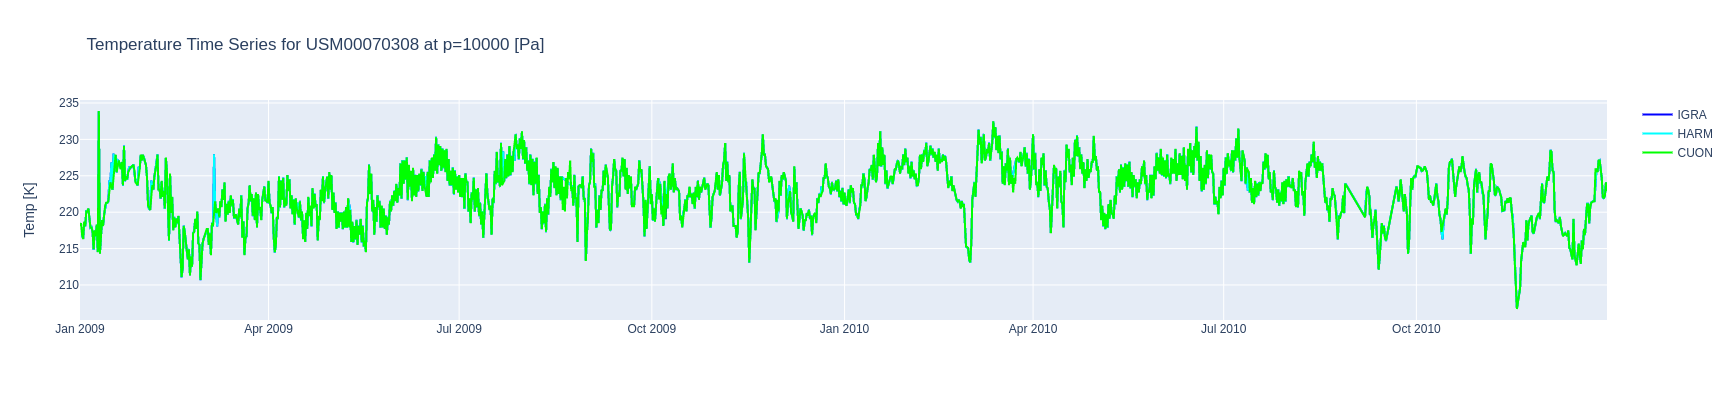

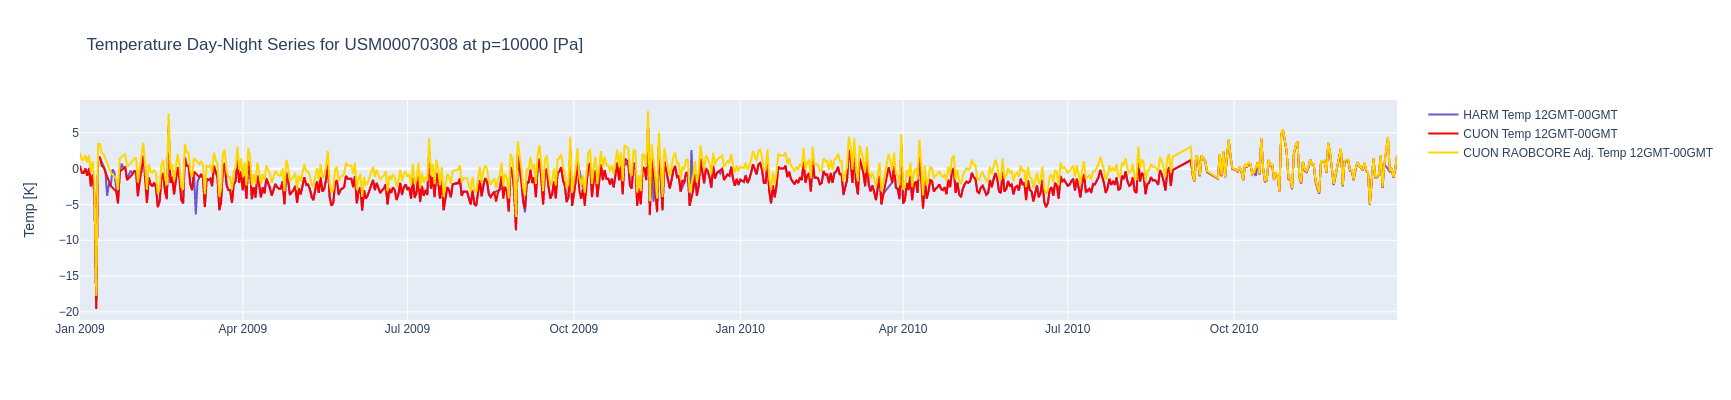

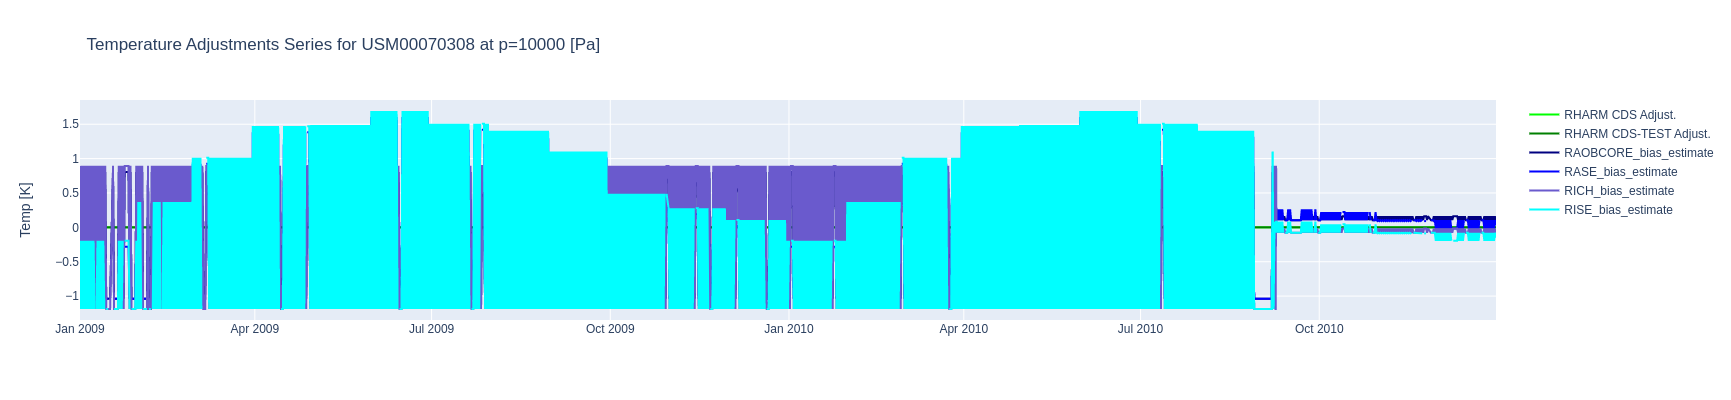

In [20]:
station, p = 'USM00070308' , 10000 
f,g = make_timeseries(station, p)
f.show()
g.show()
f,g = make_timeseries(station, p, what='ad')
f.show()
#g.show()

![pic](70316.png)

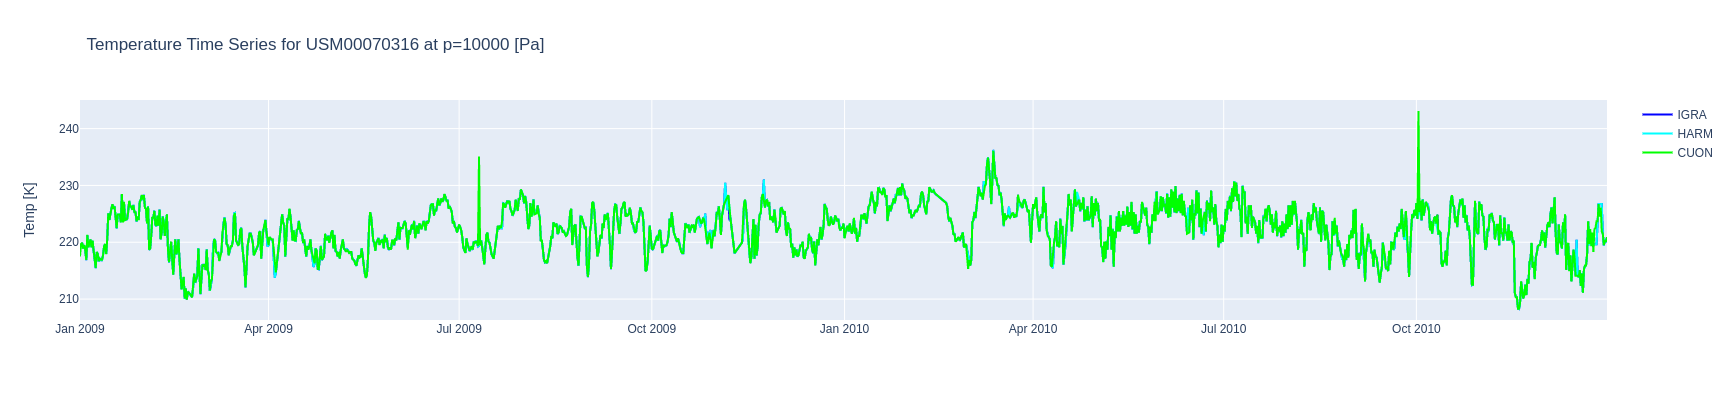

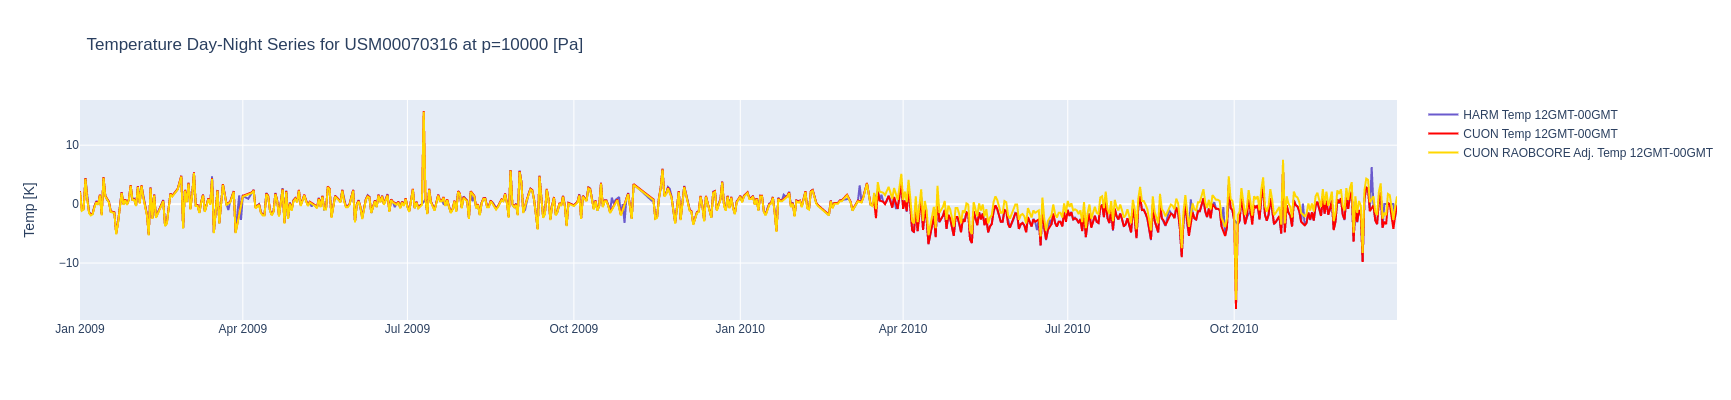

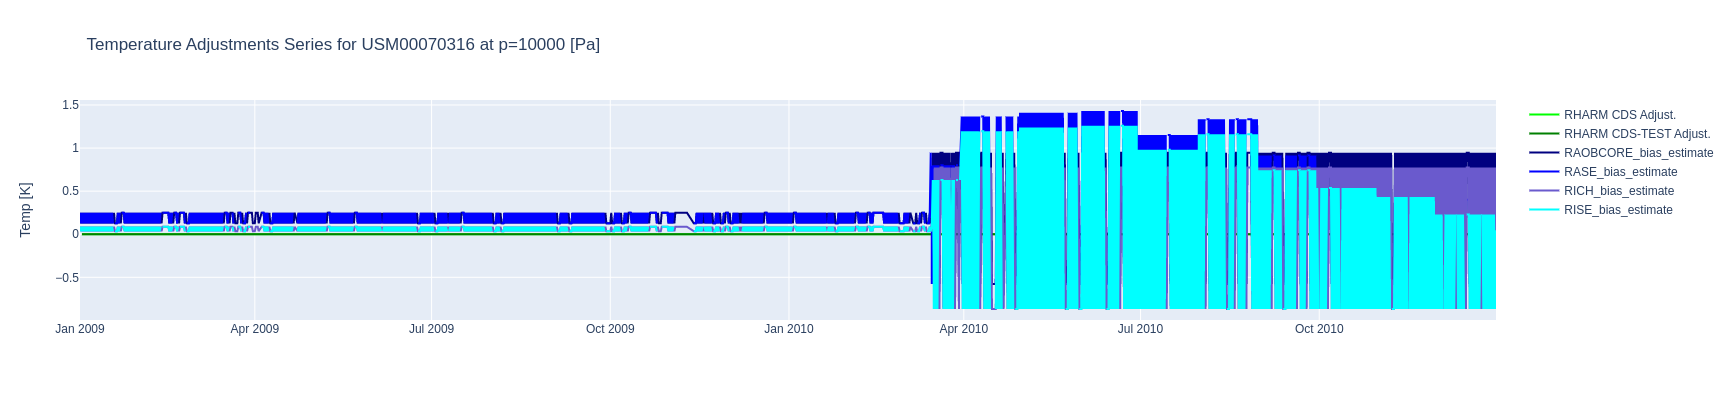

In [21]:
station, p = 'USM00070316' , 10000 
f,g = make_timeseries(station, p)
f.show()
g.show()
f,g = make_timeseries(station, p, what='ad')
f.show()
#g.show()

![pic](70350.png)

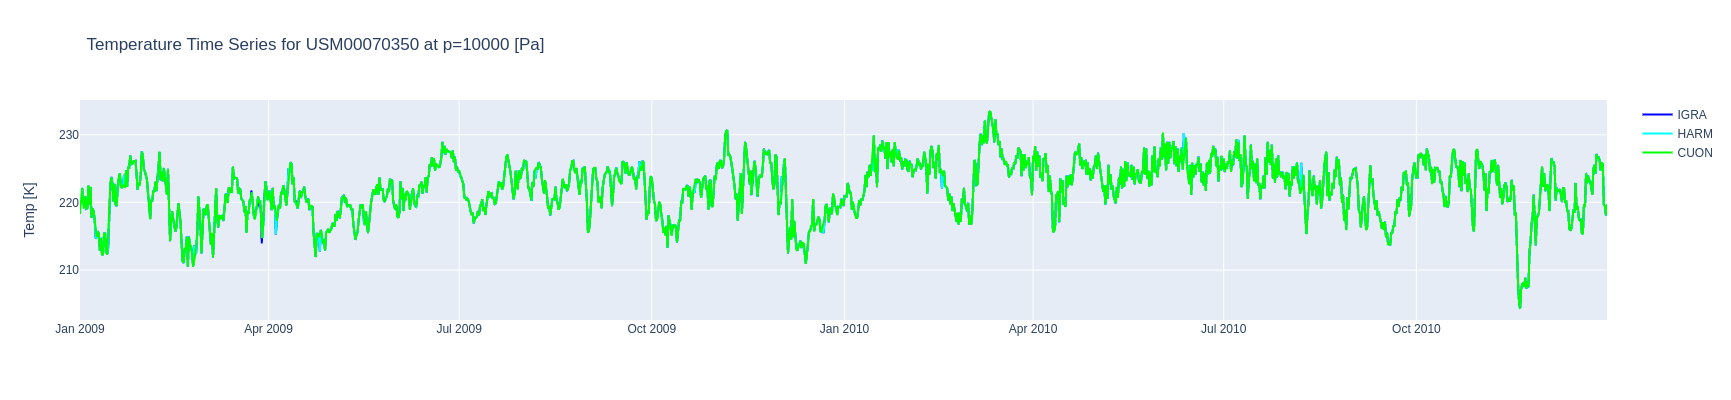

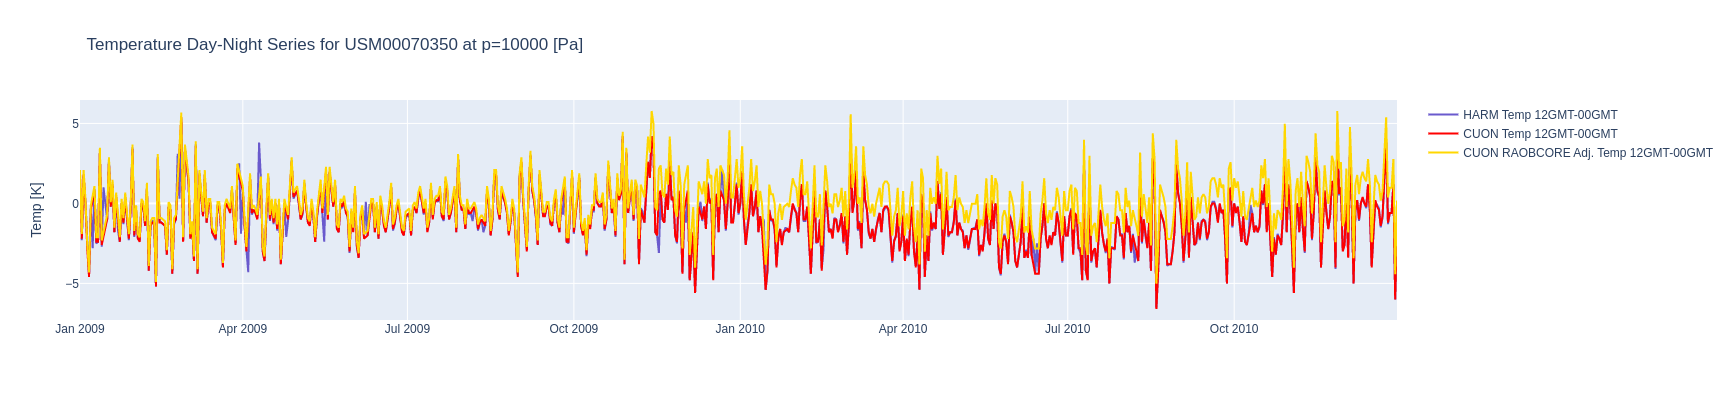

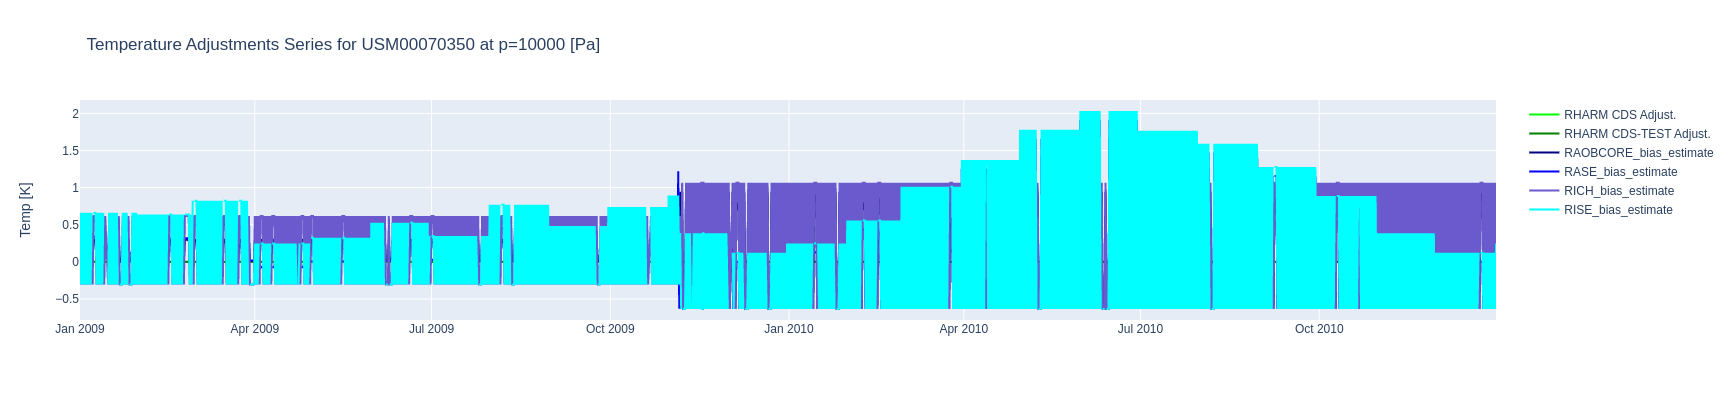

In [22]:
station, p = 'USM00070350' , 10000 
f,g = make_timeseries(station, p)
f.show()
g.show()
f,g = make_timeseries(station, p, what='ad')
f.show()
#g.show()

![pic](91408.png)

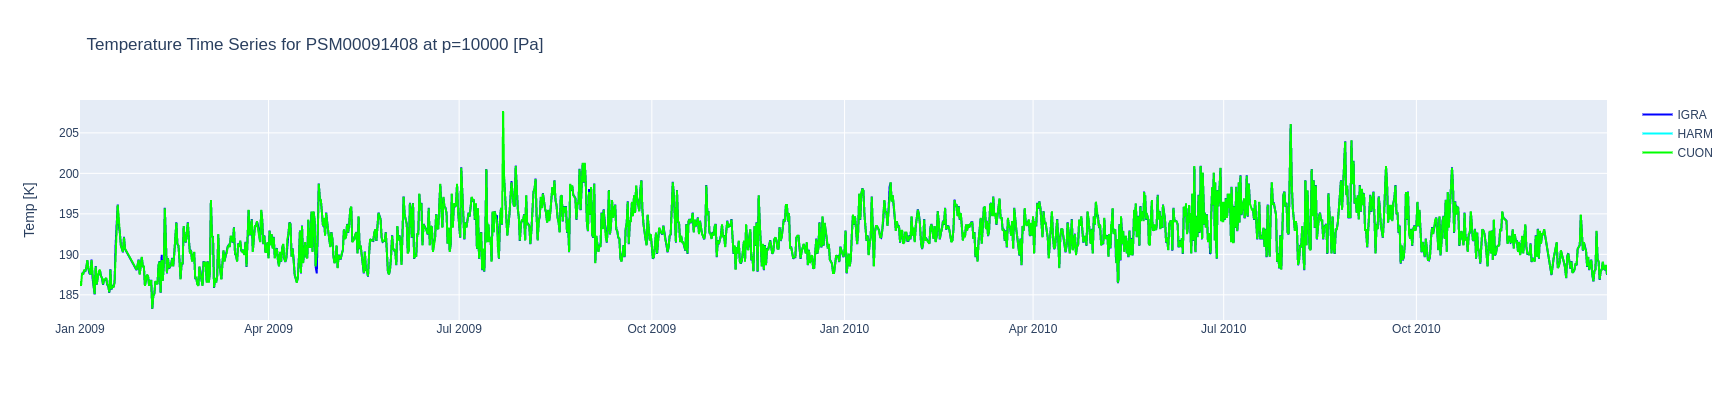

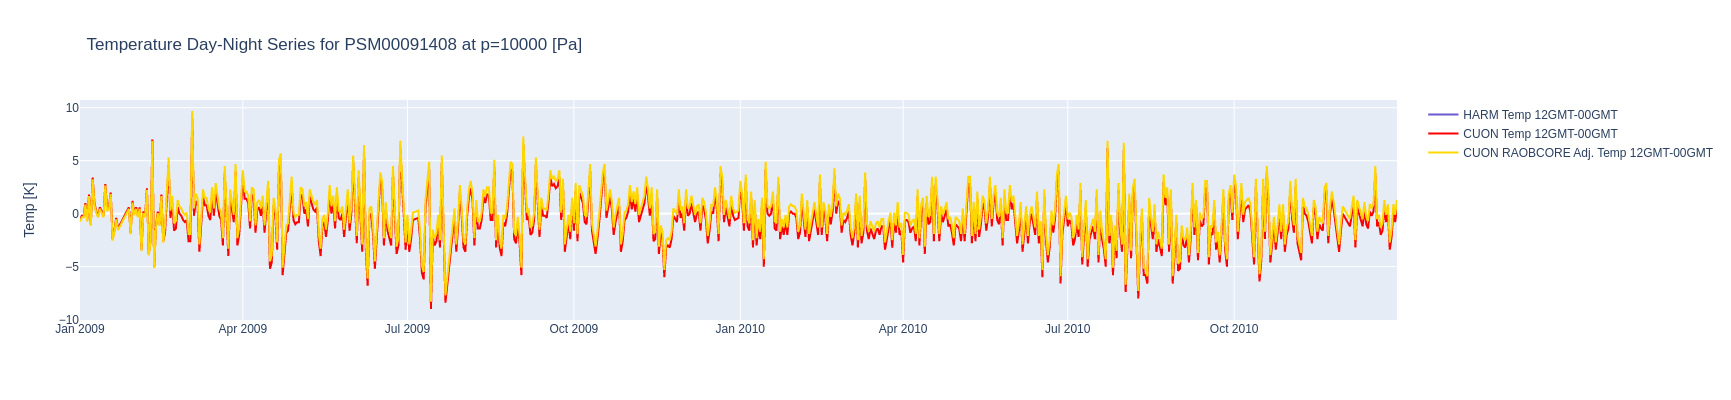

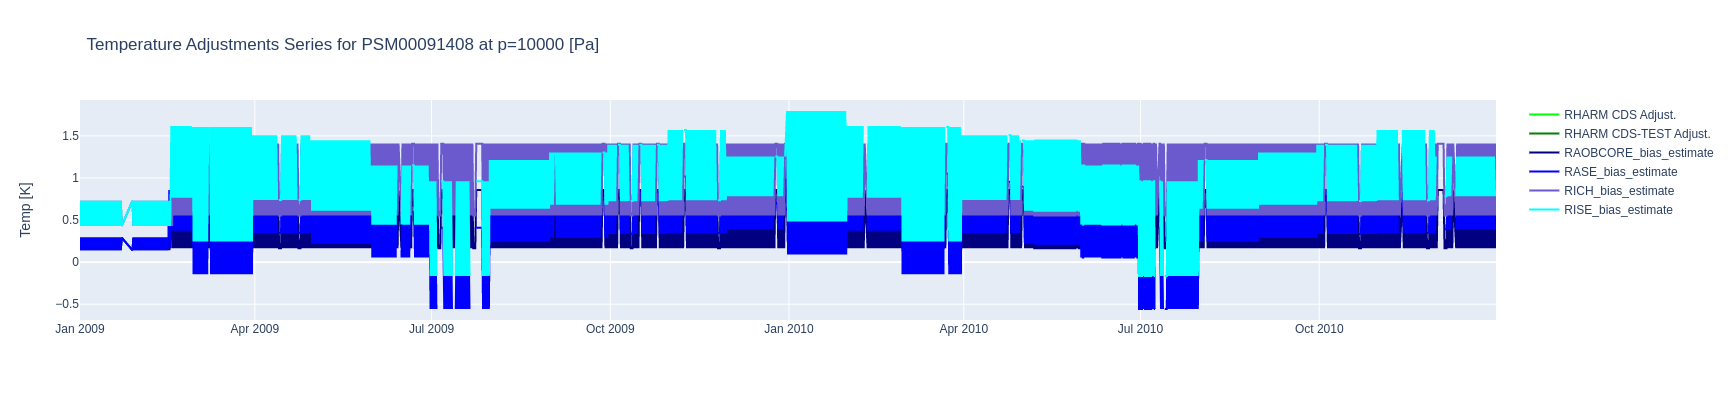

In [23]:
station, p = 'PSM00091408' , 10000 
f,g = make_timeseries(station, p)
f.show()
g.show()
f,g = make_timeseries(station, p, what='ad')
f.show()
#g.show()